In [1]:
# Import the required libraries
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from features_helper import *
from plot_helper import *
from training_helper import *

init_style()

In [2]:
data_path = 'data/diplomacy_data.json'

# Load the json data
with open(data_path) as data_file:
    data_json = json.load(data_file)

## Loading the features

In [3]:
# Get the last friendly action for each friendship
last_friendly_action = get_last_friendly_action(data_json)

In [4]:
season_features_victim = load_season_features(data_json, last_friendly_action, 'victim')
season_features_betrayer = load_season_features(data_json, last_friendly_action, 'betrayer')
season_features = pd.concat([season_features_victim, season_features_betrayer])
season_features.head()

,idx,season,betrayal,support,n_requests,n_words,politeness,n_sentences,sentiment.positive,sentiment.neutral,...,premise,expansion,comparison,planning,claim,temporal,contingency,last_season,n_messages,player_type
0,0,1906.5,True,1,3.250000,120.000000,0.809993,7.750000,1.500000,1.250000,...,4.750000,1.0,1.250000,1.000000,0.500000,1.250000,0.250000,1909.0,4,victim
1,0,1907.0,True,0,0.666667,31.000000,0.785508,3.000000,1.333333,0.666667,...,0.333333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1909.0,3,victim
2,0,1907.5,True,0,3.666667,120.000000,0.607331,9.333333,1.000000,3.666667,...,2.000000,1.0,0.333333,0.333333,0.000000,0.000000,0.333333,1909.0,3,victim
3,0,1908.0,True,0,0.500000,28.000000,0.571134,3.000000,1.000000,0.000000,...,1.000000,1.0,0.500000,1.000000,0.500000,0.500000,0.500000,1909.0,2,victim
4,0,1908.5,True,0,2.333333,85.333333,0.563423,5.000000,0.666667,1.666667,...,1.000000,1.0,0.000000,0.666667,0.333333,0.333333,0.000000,1909.0,3,victim


In [5]:
final_season_features = merge_player_features(season_features.drop(columns=['last_season', 'support']), on=['idx', 'season', 'betrayal'])
final_season_features['betrayal'] = final_season_features['betrayal'].astype(int)
final_season_features = final_season_features.drop(columns=['idx', 'season'])
final_season_features.head()

,betrayal,n_requests_victim,n_words_victim,politeness_victim,n_sentences_victim,sentiment.positive_victim,sentiment.neutral_victim,sentiment.negative_victim,subjectivity_victim,premise_victim,...,sentiment.negative_betrayer,subjectivity_betrayer,premise_betrayer,expansion_betrayer,comparison_betrayer,planning_betrayer,claim_betrayer,temporal_betrayer,contingency_betrayer,n_messages_betrayer
0,1,3.250000,120.000000,0.809993,7.750000,1.500000,1.250000,5.000000,17.000000,4.750000,...,1.500000,15.333333,1.166667,1.000000,1.000000,0.500000,0.166667,0.500000,0.333333,6
1,1,0.666667,31.000000,0.785508,3.000000,1.333333,0.666667,1.000000,4.666667,0.333333,...,1.285714,4.857143,0.428571,0.285714,0.142857,0.285714,0.142857,0.142857,0.285714,7
2,1,3.666667,120.000000,0.607331,9.333333,1.000000,3.666667,4.666667,14.666667,2.000000,...,2.000000,28.500000,1.000000,2.500000,2.000000,2.000000,2.000000,2.000000,3.500000,2
3,1,0.500000,28.000000,0.571134,3.000000,1.000000,0.000000,2.000000,5.500000,1.000000,...,2.200000,16.400000,1.200000,1.800000,0.600000,1.000000,0.200000,1.000000,1.200000,5
4,1,2.333333,85.333333,0.563423,5.000000,0.666667,1.666667,2.666667,9.333333,1.000000,...,1.000000,9.500000,1.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2


In [6]:
friendship_features = get_friendship_features(season_features)
friendship_features.head()

,idx,player_type,betrayal,mean_support,mean_n_requests,mean_n_words,mean_politeness,mean_n_sentences,mean_sentiment.positive,mean_sentiment.neutral,...,var_sentiment.negative,var_subjectivity,var_premise,var_expansion,var_comparison,var_planning,var_claim,var_temporal,var_contingency,var_n_messages
0,0,betrayer,True,1.000000,2.830952,75.411111,0.792530,3.792063,1.046032,1.192857,...,0.174455,61.610330,0.118698,0.617312,0.507596,0.420068,0.506428,0.457751,1.444826,3.805556
1,0,victim,True,0.166667,2.069444,72.972222,0.685290,5.597222,1.083333,1.458333,...,1.978395,20.374228,2.121335,0.145833,0.176890,0.175926,0.052469,0.176890,0.042631,0.472222
2,1,betrayer,False,1.000000,0.750000,12.083333,0.432853,1.416667,0.000000,0.583333,...,0.138889,1.534722,0.034722,0.145833,0.138889,0.138889,0.000000,0.000000,0.138889,0.222222
3,1,victim,False,0.200000,0.800000,22.400000,0.493841,2.400000,0.200000,1.200000,...,1.200000,2.640000,0.160000,0.640000,0.640000,0.240000,0.000000,0.160000,0.640000,0.000000
4,2,betrayer,False,0.444444,1.111111,60.888889,0.558239,2.444444,0.333333,0.666667,...,1.302469,27.388889,0.166667,0.000000,0.000000,0.000000,0.098765,0.024691,0.024691,0.172840


In [7]:
final_friendship_features = merge_player_features(friendship_features, on=['idx', 'betrayal'])
final_friendship_features['betrayal'] = final_friendship_features['betrayal'].astype(int)
final_friendship_features = final_friendship_features.drop(columns=['idx'])
final_friendship_features.head()

,betrayal,mean_support_victim,mean_n_requests_victim,mean_n_words_victim,mean_politeness_victim,mean_n_sentences_victim,mean_sentiment.positive_victim,mean_sentiment.neutral_victim,mean_sentiment.negative_victim,mean_subjectivity_victim,...,var_sentiment.negative_betrayer,var_subjectivity_betrayer,var_premise_betrayer,var_expansion_betrayer,var_comparison_betrayer,var_planning_betrayer,var_claim_betrayer,var_temporal_betrayer,var_contingency_betrayer,var_n_messages_betrayer
0,1,0.166667,2.069444,72.972222,0.685290,5.597222,1.083333,1.458333,3.055556,10.527778,...,0.174455,61.610330,0.118698,0.617312,0.507596,0.420068,0.506428,0.457751,1.444826,3.805556
1,0,0.200000,0.800000,22.400000,0.493841,2.400000,0.200000,1.200000,1.000000,2.400000,...,0.138889,1.534722,0.034722,0.145833,0.138889,0.138889,0.000000,0.000000,0.138889,0.222222
2,0,0.875000,0.750000,35.062500,0.412080,1.937500,0.187500,0.687500,1.062500,2.875000,...,1.302469,27.388889,0.166667,0.000000,0.000000,0.000000,0.098765,0.024691,0.024691,0.172840
3,0,0.250000,4.166667,120.729167,0.694526,6.208333,1.416667,1.312500,3.479167,20.083333,...,1.546875,21.130208,0.630208,1.130208,0.338542,0.520833,0.187500,0.130208,0.395833,0.500000
4,0,1.000000,3.375000,44.875000,0.572625,3.750000,0.875000,1.000000,1.875000,7.750000,...,0.366319,8.991319,0.020833,0.088542,0.131944,0.187500,0.130208,0.046875,0.166667,0.687500


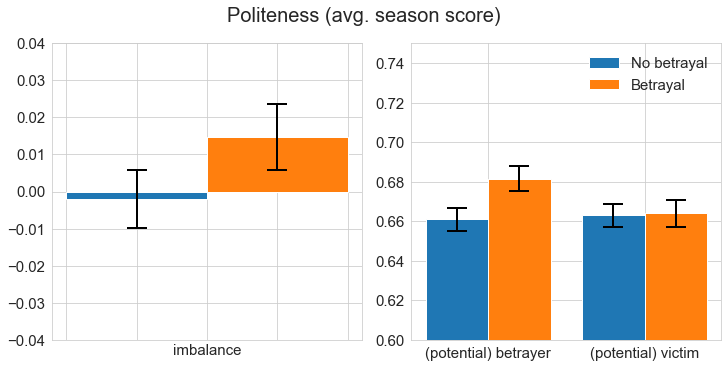

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, constrained_layout=True)
fig.suptitle('Politeness (avg. season score)')

draw_imbalance_plot(ax1, ax2, season_features, 'politeness', (-0.04, 0.04), (0.6, 0.75), True)

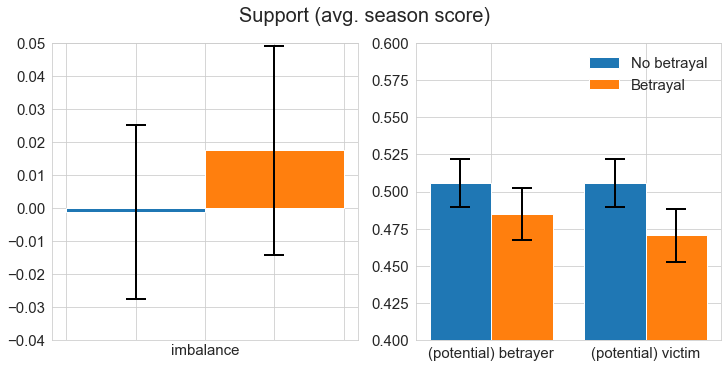

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, constrained_layout=True)
fig.suptitle('Support (avg. season score)')

draw_imbalance_plot(ax1, ax2, season_features, 'support', (-0.04, 0.05), (0.40, 0.6), True)

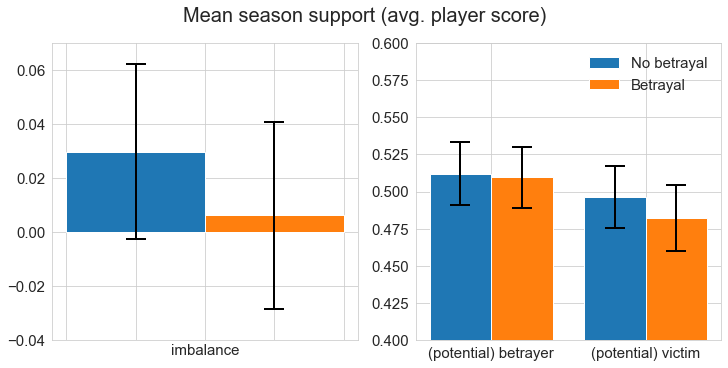

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, constrained_layout=True)
fig.suptitle('Mean season support (avg. player score)')

draw_imbalance_plot(ax1, ax2, friendship_features, 'mean_support', (-0.04, 0.07), (0.4, 0.6), True, 'friendship')

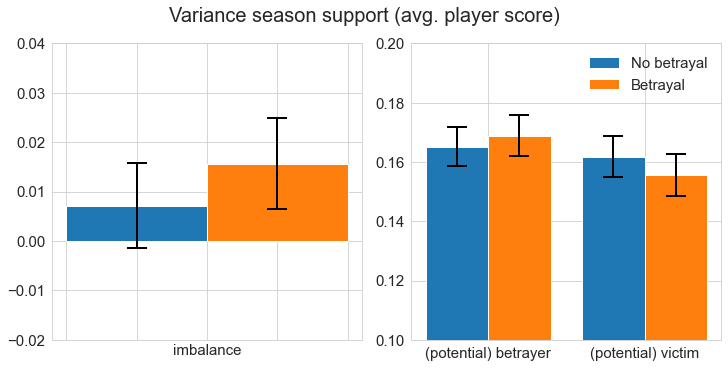

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, constrained_layout=True)
fig.suptitle('Variance season support (avg. player score)')

draw_imbalance_plot(ax1, ax2, friendship_features, 'var_support', (-0.02, 0.04), (0.10, 0.2), True, 'friendship')

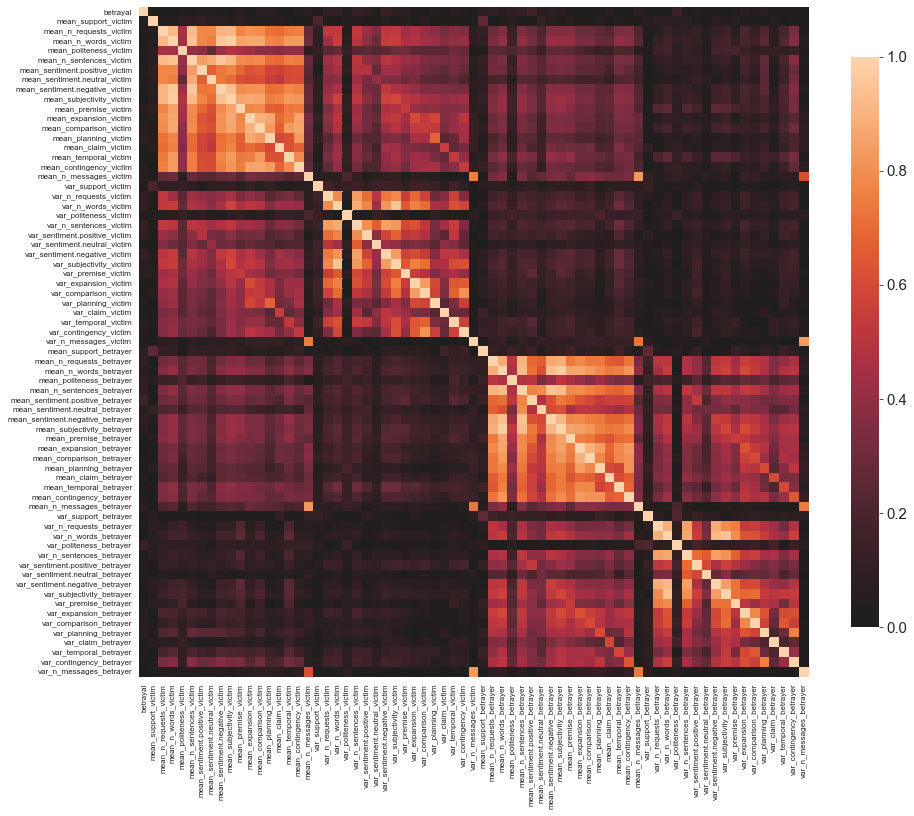

In [17]:
corr = final_friendship_features.corr().abs()
corr_plot(corr)

In [13]:
betrayal_corr = corr.loc[corr.columns[1]:, 'betrayal'].to_frame().reset_index()
betrayal_corr = betrayal_corr.rename(columns={'betrayal' : 'betrayal_correlation'})
betrayal_corr['feature_type'] = 'Mean'
betrayal_corr.loc[betrayal_corr['index'].str.startswith('var'), 'feature_type'] = 'Variance'
betrayal_corr['player'] = 'Victim'
betrayal_corr.loc[betrayal_corr['index'].str.endswith('betrayer'), 'player'] = 'Betrayer'

betrayal_corr = betrayal_corr.sort_values(by='betrayal_correlation', ascending=False)
betrayal_corr.head(5)

,index,betrayal_correlation,feature_type,player
39,mean_sentiment.positive_betrayer,0.148994,Mean,Betrayer
54,var_politeness_betrayer,0.138815,Variance,Betrayer
24,var_sentiment.negative_victim,0.119722,Variance,Victim
21,var_n_sentences_victim,0.115844,Variance,Victim
38,mean_n_sentences_betrayer,0.107543,Mean,Betrayer


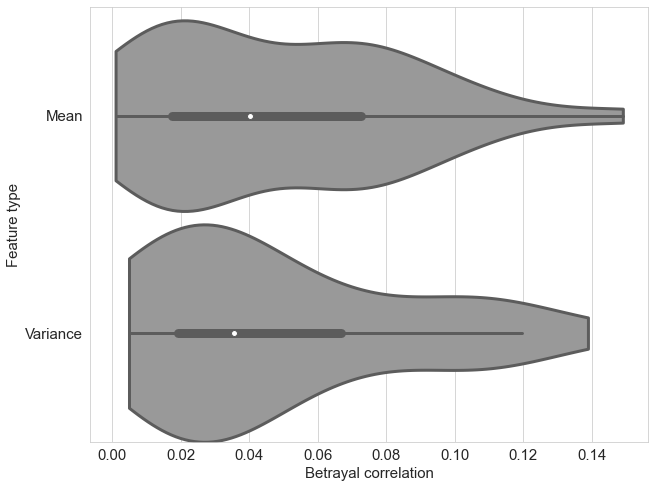

In [14]:
betrayal_corr_plot(betrayal_corr, 'feature_type', 'Feature type')

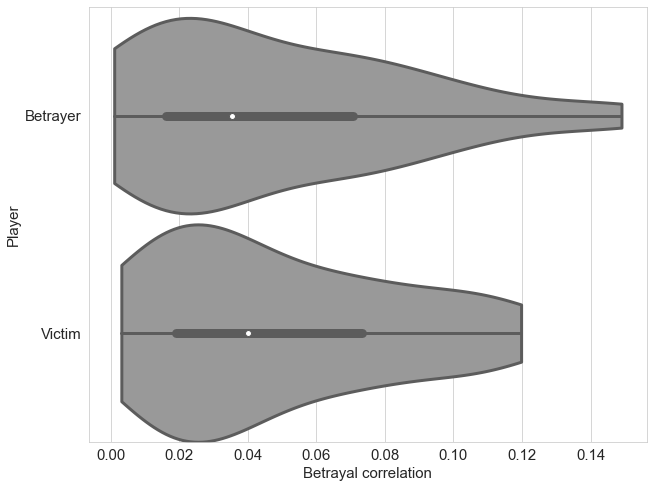

In [15]:
betrayal_corr_plot(betrayal_corr, 'player', 'Player')

### Training

In [16]:
from sklearn.preprocessing import normalize

FEATURES_PAPER = 'paper'
FEATURES_ALL = 'all'

features = [FEATURES_PAPER, FEATURES_ALL]
normalize_option = [False, True]
model_types = [MODEL_LOGIT, MODEL_GRADIENT, MODEL_FOREST]
feat_select_types = [None, FEAT_SELECT_ANOVA, FEAT_SELECT_CHI2]

nb_features = [5, 10, 20, 30, 50]
n_estimators = [50, 75, 100, 150, 200, 250] # For gradient boosting regressor and random forest
learning_rates = [0.1, 0.05, 0.01] # For gradient boosting regressor

N_FOLDS = 5

result = pd.DataFrame(columns=['Features', 'Normalize', 'Model', 'Feature selection', 'Accuracy', 'Accuracy low ci 95', 'Accuracy high ci 95', 'Model params'])

for feat in features:
    if feat == FEATURES_PAPER:
        X = final_season_features[final_season_features.columns[final_season_features.columns != 'betrayal']]
        y = final_season_features['betrayal']
    elif feat == FEATURES_ALL:
        X = final_friendship_features[final_friendship_features.columns[final_friendship_features.columns != 'betrayal']]
        y = final_friendship_features['betrayal']
    
    for norm in normalize_option:
        if norm:
            X = pd.DataFrame(normalize(X, axis=0), columns=X.columns)
        for model_type in model_types:
            for feat_select_type in feat_select_types:
                print('Features:', feat, '- Normalize:', norm, '- Model:', model_type, '- Feature selection:', feat_select_type, flush=True)
                acc, low_acc, high_acc, model_params = train_and_evaluate(model_type, feat_select_type, X, y, N_FOLDS, nb_features, n_estimators, learning_rates)
                result = result.append({'Features' : feat, 'Normalize' : norm, 'Model' : model_type, 'Feature selection' : feat_select_type, 'Accuracy' : acc, 'Accuracy low ci 95' : low_acc, 'Accuracy high ci 95' : high_acc, 'Model params' : model_params}, ignore_index=True)
result

Features: paper - Normalize: False - Model: logit - Feature selection: None


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.91s/it]

Features: paper - Normalize: False - Model: logit - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.53s/it]

Features: paper - Normalize: False - Model: logit - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.73s/it]

Features: paper - Normalize: False - Model: gradient - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:08<00:00, 37.76s/it]

Features: paper - Normalize: False - Model: gradient - Feature selection: anova



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [11:52<00:00, 142.53s/it]

Features: paper - Normalize: False - Model: gradient - Feature selection: chi2



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:41<00:00, 128.26s/it]

Features: paper - Normalize: False - Model: forest - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.66s/it]

Features: paper - Normalize: False - Model: forest - Feature selection: anova



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:43<00:00, 104.68s/it]

Features: paper - Normalize: False - Model: forest - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:49<00:00, 93.81s/it]

Features: paper - Normalize: True - Model: logit - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.72it/s]

Features: paper - Normalize: True - Model: logit - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]

Features: paper - Normalize: True - Model: logit - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]

Features: paper - Normalize: True - Model: gradient - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:12<00:00, 38.50s/it]

Features: paper - Normalize: True - Model: gradient - Feature selection: anova



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:40<00:00, 128.08s/it]

Features: paper - Normalize: True - Model: gradient - Feature selection: chi2



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:59<00:00, 119.89s/it]

Features: paper - Normalize: True - Model: forest - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.01s/it]

Features: paper - Normalize: True - Model: forest - Feature selection: anova



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:20<00:00, 100.05s/it]

Features: paper - Normalize: True - Model: forest - Feature selection: chi2



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:33<00:00, 102.75s/it]

Features: all - Normalize: False - Model: logit - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]

Features: all - Normalize: False - Model: logit - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]

Features: all - Normalize: False - Model: logit - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.21it/s]

Features: all - Normalize: False - Model: gradient - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.83s/it]

Features: all - Normalize: False - Model: gradient - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:16<00:00, 63.26s/it]

Features: all - Normalize: False - Model: gradient - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:53<00:00, 58.68s/it]

Features: all - Normalize: False - Model: forest - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.55s/it]

Features: all - Normalize: False - Model: forest - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.63s/it]

Features: all - Normalize: False - Model: forest - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.41s/it]

Features: all - Normalize: True - Model: logit - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]

Features: all - Normalize: True - Model: logit - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]

Features: all - Normalize: True - Model: logit - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]

Features: all - Normalize: True - Model: gradient - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:54<00:00, 22.81s/it]

Features: all - Normalize: True - Model: gradient - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:04<00:00, 48.95s/it]

Features: all - Normalize: True - Model: gradient - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:57<00:00, 59.47s/it]

Features: all - Normalize: True - Model: forest - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.24s/it]

Features: all - Normalize: True - Model: forest - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:17<00:00, 39.52s/it]

Features: all - Normalize: True - Model: forest - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.26s/it]


,Features,Normalize,Model,Feature selection,Accuracy,Accuracy low ci 95,Accuracy high ci 95,Model params
0,paper,False,logit,None,0.517419,0.494194,0.546452,[all]
1,paper,False,logit,anova,0.529677,0.500645,0.558710,[20]
2,paper,False,logit,chi2,0.529677,0.510323,0.543226,[5]
3,paper,False,gradient,None,0.542581,0.510968,0.574194,"[all, 50, 0.01]"
4,paper,False,gradient,anova,0.561935,0.536129,0.590371,"[5, 50, 0.01]"
5,paper,False,gradient,chi2,0.565161,0.530968,0.601290,"[5, 50, 0.01]"
6,paper,False,forest,None,0.513548,0.490323,0.528387,"[all, 50]"
7,paper,False,forest,anova,0.536774,0.521290,0.550968,"[10, 50]"
8,paper,False,forest,chi2,0.544516,0.528387,0.560645,"[10, 200]"
9,paper,True,logit,None,0.517419,0.494194,0.546452,[all]
